In [2]:
import requests
from bs4 import BeautifulSoup
import pandas as pd
import time
import matplotlib.pyplot as plt
import numpy as np
import re
import ast
import seaborn as sns
pd.set_option('display.max_columns', 100)
pd.options.display.max_rows = 4000
# import libraries
# import libraries
import pandas as pd
import sqlite3 
import matplotlib.pyplot as plt
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
import itertools
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, f1_score, recall_score
from imblearn.over_sampling import SMOTE
from collections import Counter
from imblearn.under_sampling import TomekLinks
from sklearn.neighbors import KNeighborsClassifier
from sklearn import metrics
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn import tree
from scipy.stats import chi2_contingency
from scipy.stats import chi2
import requests
import numpy as np
import json
import pandas as pd
from tqdm import tqdm
import seaborn as sns
import statsmodels.api as sm
from statsmodels.formula.api import ols
import matplotlib.pyplot as plt
import scipy.stats as stats
import math
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn import metrics
from sklearn import linear_model
from sklearn.preprocessing import StandardScaler
import warnings
from scipy.stats.stats import pearsonr
import scipy as sp
from scipy import stats
from scipy.stats import skew,norm
from sklearn.preprocessing import PolynomialFeatures
plt.style.use('seaborn')
from scipy.stats import chi2_contingency
from scipy.stats import chi2

In [3]:
##Letters to iterate through
#alphabet = ['a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'y', 'z']
##Empty lists to store our data
#names_list = []
#links_list = []
#start_list = []
#end_list = []
#pos_list = []

In [4]:
#for letter in alphabet:
#    #Link to webpage using requests and BeautifulSoup
#    page = requests.get('https://www.basketball-reference.com/players/' + letter)
#    soup = BeautifulSoup(page.content, 'html.parser')
#    
#    #Select The table then the rows
#    table = soup.find('table', class_ = 'sortable stats_table')
#    rows = table.findAll('tr')
#    
#    #Iterate through the rows and get all player names
#    new_names_list = [row.find('th') for row in rows]
#    new_names_list = [name.find('a') for name in new_names_list]
#    new_names_list = [name for name in new_names_list if name]
#    new_names_list = [name.string for name in new_names_list]
#    
#    #Iterate through the rows and get links to all player pages
#    new_links_list = [row.find('th') for row in rows]
#    new_links_list = [link.find('a') for link in new_links_list]
#    new_links_list = [link for link in new_links_list if link]
#    new_links_list = [link['href'] for link in new_links_list]
#    
#    #Iterate and get first year of a players career
#    new_start_list = [row.findAll('td') for row in rows]
#    new_start_list = [year for year in new_start_list if year]
#    new_start_list = [year[0].string for year in new_start_list]
#    
#    #Iterate and get last year
#    new_end_list = [row.findAll('td') for row in rows]
#    new_end_list = [year for year in new_end_list if year]
#    new_end_list = [year[1].string for year in new_end_list]
#    
#    #Iterate and get position
#    new_pos_list = [row.findAll('td') for row in rows]
#    new_pos_list = [pos for pos in new_pos_list if pos]
#    new_pos_list = [pos[2].string.replace('-','') for pos in new_pos_list]
#    
#    #Add the new data to our lists
#    names_list = names_list + new_names_list
#    links_list = links_list + new_links_list
#    start_list = start_list + new_start_list
#    end_list = end_list + new_end_list
#    pos_list = pos_list + new_pos_list
#    
#    
##Turn our lists into a dataframe and name the columns    
#df = pd.DataFrame([names_list, links_list, start_list, end_list, pos_list]).transpose()
#df.columns = ['Player', 'Link', 'StartYear', 'EndYear', 'Position']
#df

In [5]:
##Change data types of years to int64 and creating a column for amount of time in league
#df.StartYear = df.StartYear.astype('int64')
#df.EndYear = df.EndYear.astype('int64')
#df['Tenure'] = df.EndYear - df.StartYear

In [6]:
#df_eligible = df[(df.EndYear <= 2016) & (df.Tenure > 4)]
#df_eligible.reset_index(inplace = True, drop = True)
#Limiting our data to players who retired in 2016 or earlier so that all players are hall of fame eligible
#Also removed any player who didn't last more than 4 seasons

In [7]:

#def get_player_info(href1):
#    page = requests.get('https://www.basketball-reference.com'+str(href1))
#    #Name of Player
#    #soup = BS(page.content, 'html.parser')
#    #table_body=soup.find_all(itemprop= "name")
#    #table_body
#    #name= re.findall('<h1 itemprop=\"name\">(.*)</h1>', str(table_body))
#    #if len(name)==0:
#    #    name= re.findall('<span>(.*)</span>', str(table_body))
#    #else:
#    #    pass
#    
#    #Bio
#    soup = BeautifulSoup(page.content, 'html.parser')
#    table_body=soup.find_all('p')
#    work=table_body[0:10]
#    #print(work)
#    height= re.findall('(\d*cm)', str(work))
#    weight= re.findall('(\d*kg)', str(work))
#    bday= re.findall('data-birth=\"(\d*\-\d*\-\d*)', str(work))
#    #accolades
#    accolades_body=soup.find(id="bling")
#    All_Star_apps= re.findall('(\d*)x All Star', str(accolades_body))
#    All_NBA_apps= re.findall('(\d*)x All-NBA', str(accolades_body))
#    All_Def_apps= re.findall('(\d*)x All-Defensive', str(accolades_body))
#    HOF= re.findall('(Hall of Fame)', str(accolades_body))
#    empty_list=0
#    if len(All_Star_apps)==empty_list:
#        All_Star_apps='0'
#    else:
#        All_Star_apps=All_Star_apps[0]
#    if len(All_NBA_apps)==empty_list:
#        All_NBA_apps='0'
#    else:
#        All_NBA_apps=All_NBA_apps[0]
#    if len(All_Def_apps)==empty_list:
#        All_Def_apps='0'
#    else:
#        All_Def_apps= All_Def_apps[0]
#    if len(HOF)==empty_list:
#        HOF='0'
#    else:
#        HOF= HOF[0]
#    bio= [height[0],weight[0],bday[0],All_Star_apps,All_NBA_apps,All_Def_apps,HOF]
#    
#    #Find Stats overview, then pull out individual stats then extract the stats and make them a list
#    stats = soup.find('div', class_ = "stats_pullout")
#    cells = stats.find_all('p')
#    stats_list = list(map(lambda x : x.string, cells[3:23:2]))
#    
#    return bio + stats_list

In [8]:
#info_list = [get_player_info(link) for link in df_eligible.Link]
#Very slow

In [9]:
#df_info = pd.DataFrame(info_list, columns=['Height','Weight','Birthday','All_Star_apps','All_NBA_apps','All_Def_apps','HOF', 'Games', 'PPG', 'TRPG', 'APG', 'FG_pct', '3_pt_pct', 'FT_pct', 'eFG_pct', 'PER', 'WS'])
#df_eligible = pd.concat([df_eligible, df_info], axis = 1)
#df_eligible

#Concat the data about the players from info_list and the list of players

In [10]:
#df_eligible.shape

In [11]:
#page = requests.get("https://www.basketball-reference.com/players/n/ntilila01.html")
#soup = BeautifulSoup(page.content, 'html.parser')

In [12]:
#info = soup.find('div', id = 'meta')

In [13]:
#cells = info.find_all("p")

In [14]:
#cells

In [15]:
#cells[3]

In [16]:
#cells[3].text

In [17]:
#cells[3].text.split()

In [18]:
#df_eligible.to_csv('Scraped_NBA_Player_Stats.csv')


In [19]:
df_eligible = pd.read_csv("Scraped_NBA_Player_Stats.csv")  #Loading in the csv file into a Pandas Data Frame

In [20]:
df_eligible.isnull().sum().sort_values(ascending = False)

> Avg Games         0
Avg Games Played    0
Player              0
Link                0
StartYear           0
EndYear             0
Position            0
Tenure              0
Height              0
Weight              0
Birthday            0
All_Star_apps       0
All_NBA_apps        0
All_Def_apps        0
HOF                 0
Games               0
PPG                 0
TRPG                0
APG                 0
FG_pct              0
3_pt_pct            0
FT_pct              0
eFG_pct             0
PER                 0
WS                  0
Unnamed: 0          0
dtype: int64

In [21]:
#df_eligible = df_eligible.dropna(subset = ['WS', 'PER'])

In [22]:
#df_eligible.isnull().sum().sort_values(ascending = False)

In [23]:
all_time_scorers = df_eligible[['Player', 'PPG', 'Height']].groupby(['Player']).sum()
all_time_scorers = all_time_scorers.reset_index()
all_time_scorers.columns = ['Player', 'PPG', 'Height']
all_time_scorers = all_time_scorers.sort_values(by='PPG', ascending=False).head(20)
all_time_scorers

,Player,PPG,Height
365,Eddie Johnson,31.1,389
812,Michael Jordan,30.1,198
22,Allen Iverson,26.7,183
427,George Gervin,25.1,201
641,Karl Malone,25.0,206
685,Kobe Bryant,25.0,198
329,Dominique Wilkins,24.8,203
956,Rick Barry,24.8,201
639,Kareem Abdul-Jabbar,24.6,218
697,Larry Bird,24.3,206


In [24]:
#sns.set_style('darkgrid')
#fig = plt.figure(figsize = (30,30))
#fig.subplots_adjust(hspace = .25)
##ax1 and ax2 explain the relationship between attending college and having a longer than average career
#ax1 = fig.add_subplot(321)
#ax1.hist(df_eligible['Position'], bins = 20, alpha = .50,edgecolor= 'black',color ='lightblue')
#ax1.set_xlabel('Position', fontsize = 20)
#ax1.set_ylabel('# Players',fontsize = 20)
#ax1.set_title('# of Players By Position',fontsize = 30,fontweight='bold')
#
#

In [25]:
df_eligible['Height'] = (df_eligible['Height'].str.strip('cm').astype(int))

AttributeError: Can only use .str accessor with string values!

In [26]:
df_eligible['Weight'] = (df_eligible['Weight'].str.strip('kg').astype(int))

AttributeError: Can only use .str accessor with string values!

In [27]:
df_eligible['Avg Games Played']= df_eligible['Games']/df_eligible['Tenure']

In [28]:
df_eligible['Avg Games Played'].mean()

61.22609014409715

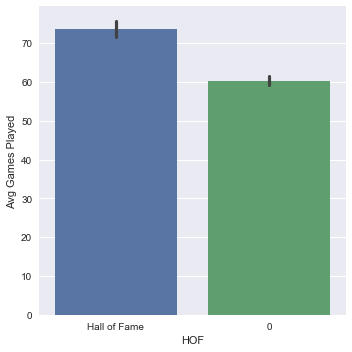

In [36]:
sns.catplot(x="HOF", y="Avg Games Played", data=df_eligible, kind='bar')

Avg height by position

What Position gets voted to the HOF more?

In [31]:
df_HOF= df_eligible[df_eligible['HOF']=='Hall of Fame']

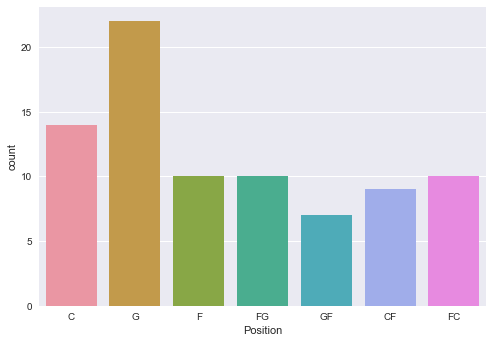

In [32]:
sns.countplot(x="Position", data= df_HOF);

Average Tenure of a HOF

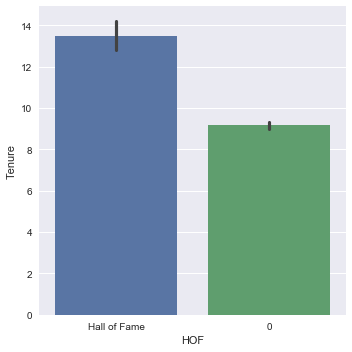

In [33]:
sns.catplot(x="HOF", y="Tenure", data=df_eligible, kind='bar');

In [159]:
df_eligible

,Player,Link,StartYear,EndYear,Position,Tenure,Height,Weight,Birthday,All_Star_apps,All_NBA_apps,All_Def_apps,HOF,Games,PPG,TRPG,APG,FG_pct,3_pt_pct,FT_pct,eFG_pct,PER,WS,Avg Games Played,> Avg Games
1,Kareem Abdul-Jabbar,/players/a/abdulka01.html,1970,1989,C,19,218,102,1947-04-16,19,15,11,Hall of Fame,1560,24.6,11.2,3.6,55.9,5.6,72.1,55.9,24.6,273.4,82.105263,1
2,Mahmoud Abdul-Rauf,/players/a/abdulma02.html,1991,2001,G,10,185,73,1969-03-09,0,0,0,0,586,14.6,1.9,3.5,44.2,35.4,90.5,47.2,15.4,25.2,58.600000,0
3,Tariq Abdul-Wahad,/players/a/abdulta01.html,1998,2003,F,5,198,101,1974-11-03,0,0,0,0,236,7.8,3.3,1.1,41.7,23.7,70.3,42.2,11.4,3.5,47.200000,0
4,Shareef Abdur-Rahim,/players/a/abdursh01.html,1997,2008,F,11,206,102,1976-12-11,1,0,0,0,830,18.1,7.5,2.5,47.2,29.7,81.0,47.9,19.0,71.2,75.454545,1
5,Mark Acres,/players/a/acresma01.html,1988,1993,FC,5,211,99,1962-11-15,0,0,0,0,375,3.6,4.1,0.5,50.6,53.8,66.5,50.9,9.0,9.3,75.000000,1
6,Alvan Adams,/players/a/adamsal01.html,1976,1988,CF,12,206,95,1954-07-19,1,0,0,0,988,14.1,7.0,4.1,49.8,13.3,78.8,49.8,18.3,73.5,82.333333,1
7,Don Adams,/players/a/adamsdo01.html,1971,1977,F,6,198,95,1947-11-27,0,0,0,0,523,8.8,5.6,1.9,40.2,0.0,74.1,40.2,10.7,11.7,87.166667,1
8,Michael Adams,/players/a/adamsmi01.html,1986,1996,G,10,178,73,1963-01-19,1,0,0,0,653,14.7,2.9,6.4,41.5,33.2,84.9,47.5,16.6,46.9,65.300000,1
9,Rafael Addison,/players/a/addisra01.html,1987,1997,FG,10,201,97,1964-07-22,0,0,0,0,379,5.8,2.1,0.9,44.9,28.2,77.2,46.6,10.5,4.9,37.900000,0
11,Mark Aguirre,/players/a/aguirma01.html,1982,1994,FG,12,198,105,1959-12-10,3,0,0,0,923,20.0,5.0,3.1,48.4,31.2,74.1,49.8,19.0,67.8,76.916667,1


In [160]:
X = df_eligible[['Position', 'Tenure', 'Height', 'Weight', 'Birthday', 'All_Star_apps', 'All_NBA_apps', 'All_Def_apps', 'Games', 'PPG', 'TRPG', 'APG', 'FG_pct', '3_pt_pct', 'FT_pct', 'eFG_pct', 'PER', 'WS', 'Avg Games Played']]
y = df_eligible.HOF
y = y.replace('Hall of Fame', 1)
y = y.astype('int64')            
             
       

## Hypothesis Testing
             

In [161]:
df_eligible

,Player,Link,StartYear,EndYear,Position,Tenure,Height,Weight,Birthday,All_Star_apps,All_NBA_apps,All_Def_apps,HOF,Games,PPG,TRPG,APG,FG_pct,3_pt_pct,FT_pct,eFG_pct,PER,WS,Avg Games Played,> Avg Games
1,Kareem Abdul-Jabbar,/players/a/abdulka01.html,1970,1989,C,19,218,102,1947-04-16,19,15,11,Hall of Fame,1560,24.6,11.2,3.6,55.9,5.6,72.1,55.9,24.6,273.4,82.105263,1
2,Mahmoud Abdul-Rauf,/players/a/abdulma02.html,1991,2001,G,10,185,73,1969-03-09,0,0,0,0,586,14.6,1.9,3.5,44.2,35.4,90.5,47.2,15.4,25.2,58.600000,0
3,Tariq Abdul-Wahad,/players/a/abdulta01.html,1998,2003,F,5,198,101,1974-11-03,0,0,0,0,236,7.8,3.3,1.1,41.7,23.7,70.3,42.2,11.4,3.5,47.200000,0
4,Shareef Abdur-Rahim,/players/a/abdursh01.html,1997,2008,F,11,206,102,1976-12-11,1,0,0,0,830,18.1,7.5,2.5,47.2,29.7,81.0,47.9,19.0,71.2,75.454545,1
5,Mark Acres,/players/a/acresma01.html,1988,1993,FC,5,211,99,1962-11-15,0,0,0,0,375,3.6,4.1,0.5,50.6,53.8,66.5,50.9,9.0,9.3,75.000000,1
6,Alvan Adams,/players/a/adamsal01.html,1976,1988,CF,12,206,95,1954-07-19,1,0,0,0,988,14.1,7.0,4.1,49.8,13.3,78.8,49.8,18.3,73.5,82.333333,1
7,Don Adams,/players/a/adamsdo01.html,1971,1977,F,6,198,95,1947-11-27,0,0,0,0,523,8.8,5.6,1.9,40.2,0.0,74.1,40.2,10.7,11.7,87.166667,1
8,Michael Adams,/players/a/adamsmi01.html,1986,1996,G,10,178,73,1963-01-19,1,0,0,0,653,14.7,2.9,6.4,41.5,33.2,84.9,47.5,16.6,46.9,65.300000,1
9,Rafael Addison,/players/a/addisra01.html,1987,1997,FG,10,201,97,1964-07-22,0,0,0,0,379,5.8,2.1,0.9,44.9,28.2,77.2,46.6,10.5,4.9,37.900000,0
11,Mark Aguirre,/players/a/aguirma01.html,1982,1994,FG,12,198,105,1959-12-10,3,0,0,0,923,20.0,5.0,3.1,48.4,31.2,74.1,49.8,19.0,67.8,76.916667,1


## Chi-Squared Test

Null: There is no relationship between the Position and height of a player

Alternative: There is a relationship between the Position and height of a player

We CAN reject the null hypothesis because chi square statistic (2164.641) is greater than the critical value (192.700)


In [145]:
df_chi = df10.groupby('Position')['Height'].value_counts()
df_chi2 = df_chi.unstack()
df_chi2.fillna(0,inplace = True)
df_chi2.head()

Height,160,165,168,170,173,175,178,180,183,185,188,190,193,196,198,201,203,206,208,211,213,216,218,221,224,226,229,231
Position,,,,,,,,,,,,,,,,,,,,,,,,,,,,
C,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,6.0,19.0,33.0,42.0,12.0,12.0,4.0,2.0,1.0,2.0,2.0
CF,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,4.0,14.0,28.0,22.0,10.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0
F,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,19.0,66.0,59.0,75.0,29.0,7.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
FC,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,6.0,13.0,26.0,57.0,35.0,27.0,3.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
FG,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,3.0,13.0,20.0,29.0,13.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [148]:

# contingency table
stat, p, dof, expected = chi2_contingency(df_chi2)
print(expected)

#interpret test-statistic
prob = 0.95
critical = chi2.ppf(prob, dof)
print('probability=%.3f, critical=%.3f, stat=%.3f)' % (prob, critical, stat))
if abs(stat) >= critical:
    print('Dependent (reject H0)')
else:
    print('Independent (fail to reject H0)')
    
#interpret p-value
alpha= 1-prob
print('signigicance=%.3f, p=%.3f,' % (alpha, p))
if p <= alpha:
    print('Dependent (reject H0)')
else: 
    print('Independent (fail to reject)')

[[ 0.11083744  0.11083744  0.11083744  0.11083744  0.11083744  0.22167488
   0.88669951  1.33004926  3.54679803  6.65024631  7.09359606  8.6453202
   8.20197044  9.5320197  11.30541872 15.40640394 11.97044335 17.17980296
  12.30295567  9.86453202  6.09605911  1.55172414  1.33004926  0.44334975
   0.33251232  0.11083744  0.22167488  0.22167488]
 [ 0.06732348  0.06732348  0.06732348  0.06732348  0.06732348  0.13464696
   0.53858785  0.80788177  2.1543514   4.03940887  4.30870279  5.25123153
   4.9819376   5.78981938  6.86699507  9.35796388  7.27093596 10.43513957
   7.4729064   5.99178982  3.70279146  0.94252874  0.80788177  0.26929392
   0.20197044  0.06732348  0.13464696  0.13464696]
 [ 0.21264368  0.21264368  0.21264368  0.21264368  0.21264368  0.42528736
   1.70114943  2.55172414  6.8045977  12.75862069 13.6091954  16.5862069
  15.73563218 18.28735632 21.68965517 29.55747126 22.96551724 32.95977011
  23.60344828 18.92528736 11.6954023   2.97701149  2.55172414  0.85057471
   0.6379310

## Chi-Squared Test

Is there a relationship between the team position of a player and if they will make the Hall of Fame?



Null: There is no relationship between the Position and making the Hall of Fame

Alternative: There is a relationship between the Position and making the Hall of Fame

We CAN reject the null hypothesis because chi square statistic (13.613) is greater than the critical value (12.592)

In [162]:
df_chi = df10.groupby('Position')['HOF'].value_counts()
df_chi2 = df_chi.unstack()
df_chi2.fillna(0,inplace = True)
df_chi2.head()

HOF,0,Hall of Fame
Position,,
C,121,14
CF,73,9
F,249,10
FC,159,10
FG,70,10


In [163]:

# contingency table
stat, p, dof, expected = chi2_contingency(df_chi2)
print(expected)

#interpret test-statistic
prob = 0.95
critical = chi2.ppf(prob, dof)
print('probability=%.3f, critical=%.3f, stat=%.3f)' % (prob, critical, stat))
if abs(stat) >= critical:
    print('Dependent (reject H0)')
else:
    print('Independent (fail to reject H0)')
    
#interpret p-value
alpha= 1-prob
print('signigicance=%.3f, p=%.3f,' % (alpha, p))
if p <= alpha:
    print('Dependent (reject H0)')
else: 
    print('Independent (fail to reject)')

[[125.91133005   9.08866995]
 [ 76.47947455   5.52052545]
 [241.56321839  17.43678161]
 [157.62233169  11.37766831]
 [ 74.61412151   5.38587849]
 [355.34975369  25.65024631]
 [104.45977011   7.54022989]]
probability=0.950, critical=12.592, stat=13.613)
Dependent (reject H0)
signigicance=0.050, p=0.034,
Dependent (reject H0)


## Two Sample T Test

Is there a relationship between average games played and making the Hall of Fame?

Hypothesis Testing:

Null: No statistical difference between average games played and whether or not players make the Hall of Fame
Alternative: There is a statistical difference between average games played and whether or not players make the Hall of Fame

We CAN reject the null hypothesis because our pvalue (9.540838228486468e-22) is less than 0.05 (alpha set at .05)

What we see from this T-test is the more minutes a rookie gets the more likely he is to play five or more seasons.

In [44]:
df10 = df10.rename({'Avg Games Played': 'avg_games_played'}, axis=1)  # rename column

In [56]:
no_hof = df10[df10['HOF']=='0']
yes_hof = df10[df10['HOF']=='Hall of Fame']

In [57]:
stats.ttest_ind(no_hof['avg_games_played'],yes_hof['avg_games_played'], equal_var = False)



Ttest_indResult(statistic=-11.47202617482838, pvalue=9.540838228486468e-22)